In [1]:
import sys
sys.path.append('../../code/')

In [2]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs.visuals import vis

from libs.visuals import gridline
from libs.visuals import gridcons
from libs.metrics import aggregators

Available LLMs: (24): llama-3.1-8b llama-4-scout llama-4-mav gpt-oss-20b gpt-oss-120b qwen3-8b qwen3-14b qwen3-32b qwen3-30b-a3b-2507 qwen3-235b-a22b-2507 gemma-3-12b gemma-3-27b mistral-small-3.2-24b mistral-medium-3 llama-3.1-70b llama-3.3-70b llama-3.1-405b grok-4-fast deepseek-chat-v3.1 deepseek-r1-0528 gemini-2.5-flash gemini-2.5-flash-grounded gemini-2.5-pro gemini-2.5-pro-grounded


/home/espinl/.conda/envs/py311_llmscholar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup

In [3]:
BENCHMARKS_PATH = '../../results/temperature_analysis/benchmarks/'

PLOTS_PATH = '../../results/interventions/plots'
TABLES_PATH = '../../results/interventions/tables'
LATEX_PATH = '../../results/interventions/latex'

io.validate_path(PLOTS_PATH)
io.validate_path(TABLES_PATH)
io.validate_path(LATEX_PATH)

## Data

In [4]:
PREFIX = 'temperature'

In [5]:
files = io.get_files(BENCHMARKS_PATH, f'{PREFIX}_per_attempt_*.csv')
df_per_attempt_all = io.pd.concat([io.read_csv(fn, index_col=0, low_memory=False) for fn in files], ignore_index=True)
df_per_attempt_all.shape

(178857, 15)

In [6]:
# filtering out interventions (biased prompts and rag)
query_infra = constants.EXPERIMENT_TYPE_QUERY_TO_FILTER_RECORDS['temperature']
df_per_attempt = df_per_attempt_all.query(query_infra).copy()
df_per_attempt.shape

(106284, 15)

# Plots

In [7]:
vis.sns_reset()
vis.sns_paper_style(font_scale=constants.FONT_SCALE)

## Model group and Temperature groups

In [8]:
df_summary_temperature_group = io.pd.DataFrame()
for group in constants.BENCHMARK_MODEL_GROUPS:
    groupby = [group, 'temperature', 'metric_name']
    per_group = aggregators.aggregate_per_group(df_per_attempt, groupby, alpha=0.05, metric_value_col='metric_value', metric_name_col='metric_name')
    per_group.rename(columns={group: 'model_kind'}, inplace=True)
    per_group.loc[:, 'model_group'] = group
    cols_order = ['model_group','model_kind', 'temperature', 'n','metric_name','mean','std','median','sum','ci','ci_low','ci_high']
    per_group = per_group[cols_order]
    df_summary_temperature_group = io.pd.concat([df_summary_temperature_group, per_group], axis=0, ignore_index=True)

df_summary_temperature_group.shape

(1176, 12)

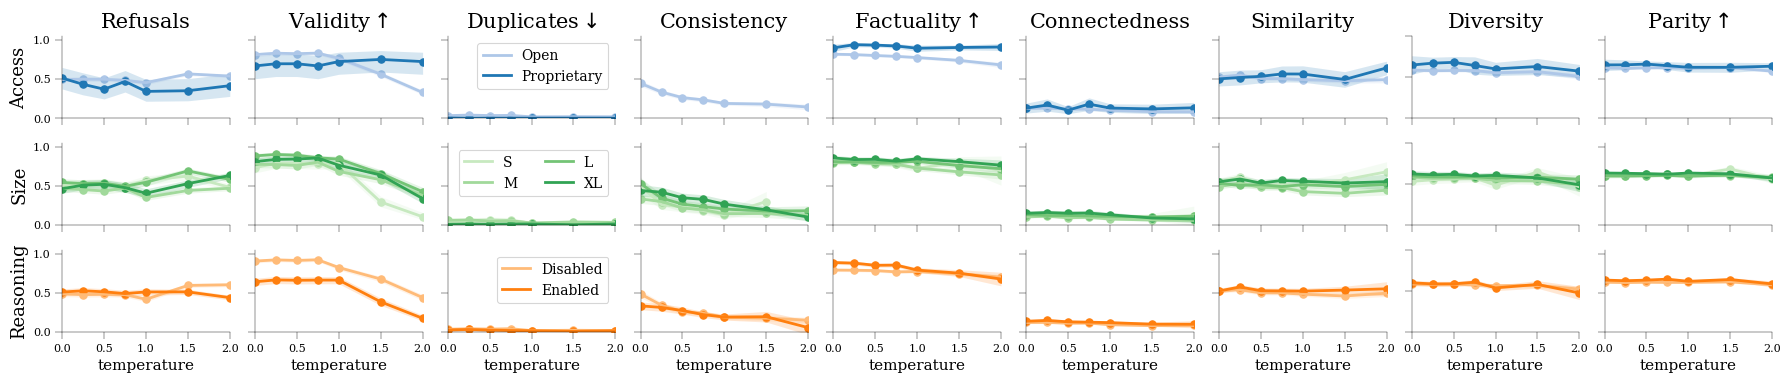

In [9]:
index = ['model_group','model_kind', 'temperature']
hue_colors = {sg:gridcons.GROUP_COLORS[group][i] for group, values in constants.BENCHMARK_MODEL_GROUP_ORDER_WITHIN_GROUP.items() for i, sg in enumerate(values)}
group_order = constants.BENCHMARK_MODEL_GROUPS

values = (
    df_summary_temperature_group.pivot(index=index, columns='metric_name', values='mean')
)

ci_low = (
    df_summary_temperature_group.pivot(index=index, columns='metric_name', values='ci_low')
)

ci_high = (
    df_summary_temperature_group.pivot(index=index, columns='metric_name', values='ci_high')
)


fig = gridline.plot_metric_grid_temperature_from_pivot(
    values,
    ci_low=ci_low,
    ci_high=ci_high,
    panels=gridcons.PANELS_METRICS,  # your PanelSpec list
    left_group_cols=[index[0]],
    series_col=index[1],
    row_label_maps={'model_group':constants.BENCHMARK_MODEL_GROUPS_LABEL_MAP},
    x_col=index[2],
    series_colors=hue_colors,
    group_order=group_order,
    series_order=constants.BENCHMARK_MODEL_GROUP_ORDER_WITHIN_GROUP,
    series_label_map = {k:v for k,v in constants.BENCHMARK_MODEL_GROUP_LABEL_MAP.items() if k not in constants.BENCHMARK_MODEL_GROUP_ORDER_WITHIN_GROUP['model_size']},
    layout=gridline.LayoutSpec(figsize=(18, 4.), wspace=0.15, separator_lw=0.5, label_ratio=0.1),
    style=gridline.StyleSpec(title_fontsize=gridcons.TITLE_FONT_SIZE, 
                             spine_lw=gridcons.SPINE_LW,
                             ylabel_fontsize=gridcons.YLABEL_FONT_SIZE, 
                             tick_fontsize=gridcons.TICK_FONT_SIZE, tick_font_color=gridcons.TICK_FONT_COLOR,
                             value_fontsize=10, 
                             legend_fontsize=10, legend_frameon=True, row_label_x=-0.3, grid_x=False, grid_y=False, ylabel_pad=10),

    add_legend=True,
    legend_panel=[(0, 2),(1,2),(2,2)],
    legend_kwargs = [{}, {'ncols':2}, {}]
)

fn = io.path_join(PLOTS_PATH, f'{PREFIX}_by_model_group.pdf')
if fn is not None:
    fig.savefig(fn, dpi=constants.FIG_DPI, bbox_inches='tight')

gridline.plt.show()
gridline.plt.close()

## By model

In [10]:
groupby = ['model', 'temperature', 'metric_name']
df_summary_temperature_model = aggregators.aggregate_per_group(df_per_attempt, groupby, alpha=0.05, metric_value_col='metric_value', metric_name_col='metric_name')
cols_order = ['model', 'temperature', 'n','metric_name','mean','std','median','sum','ci','ci_low','ci_high']
df_summary_temperature_model = df_summary_temperature_model[cols_order]
# df_summary_temperature_model.loc[:, 'dummy'] = 1
df_summary_temperature_model.loc[:, 'provider'] = df_summary_temperature_model.model.str.split('-').str[0]

df_summary_temperature_model.shape

(3050, 12)

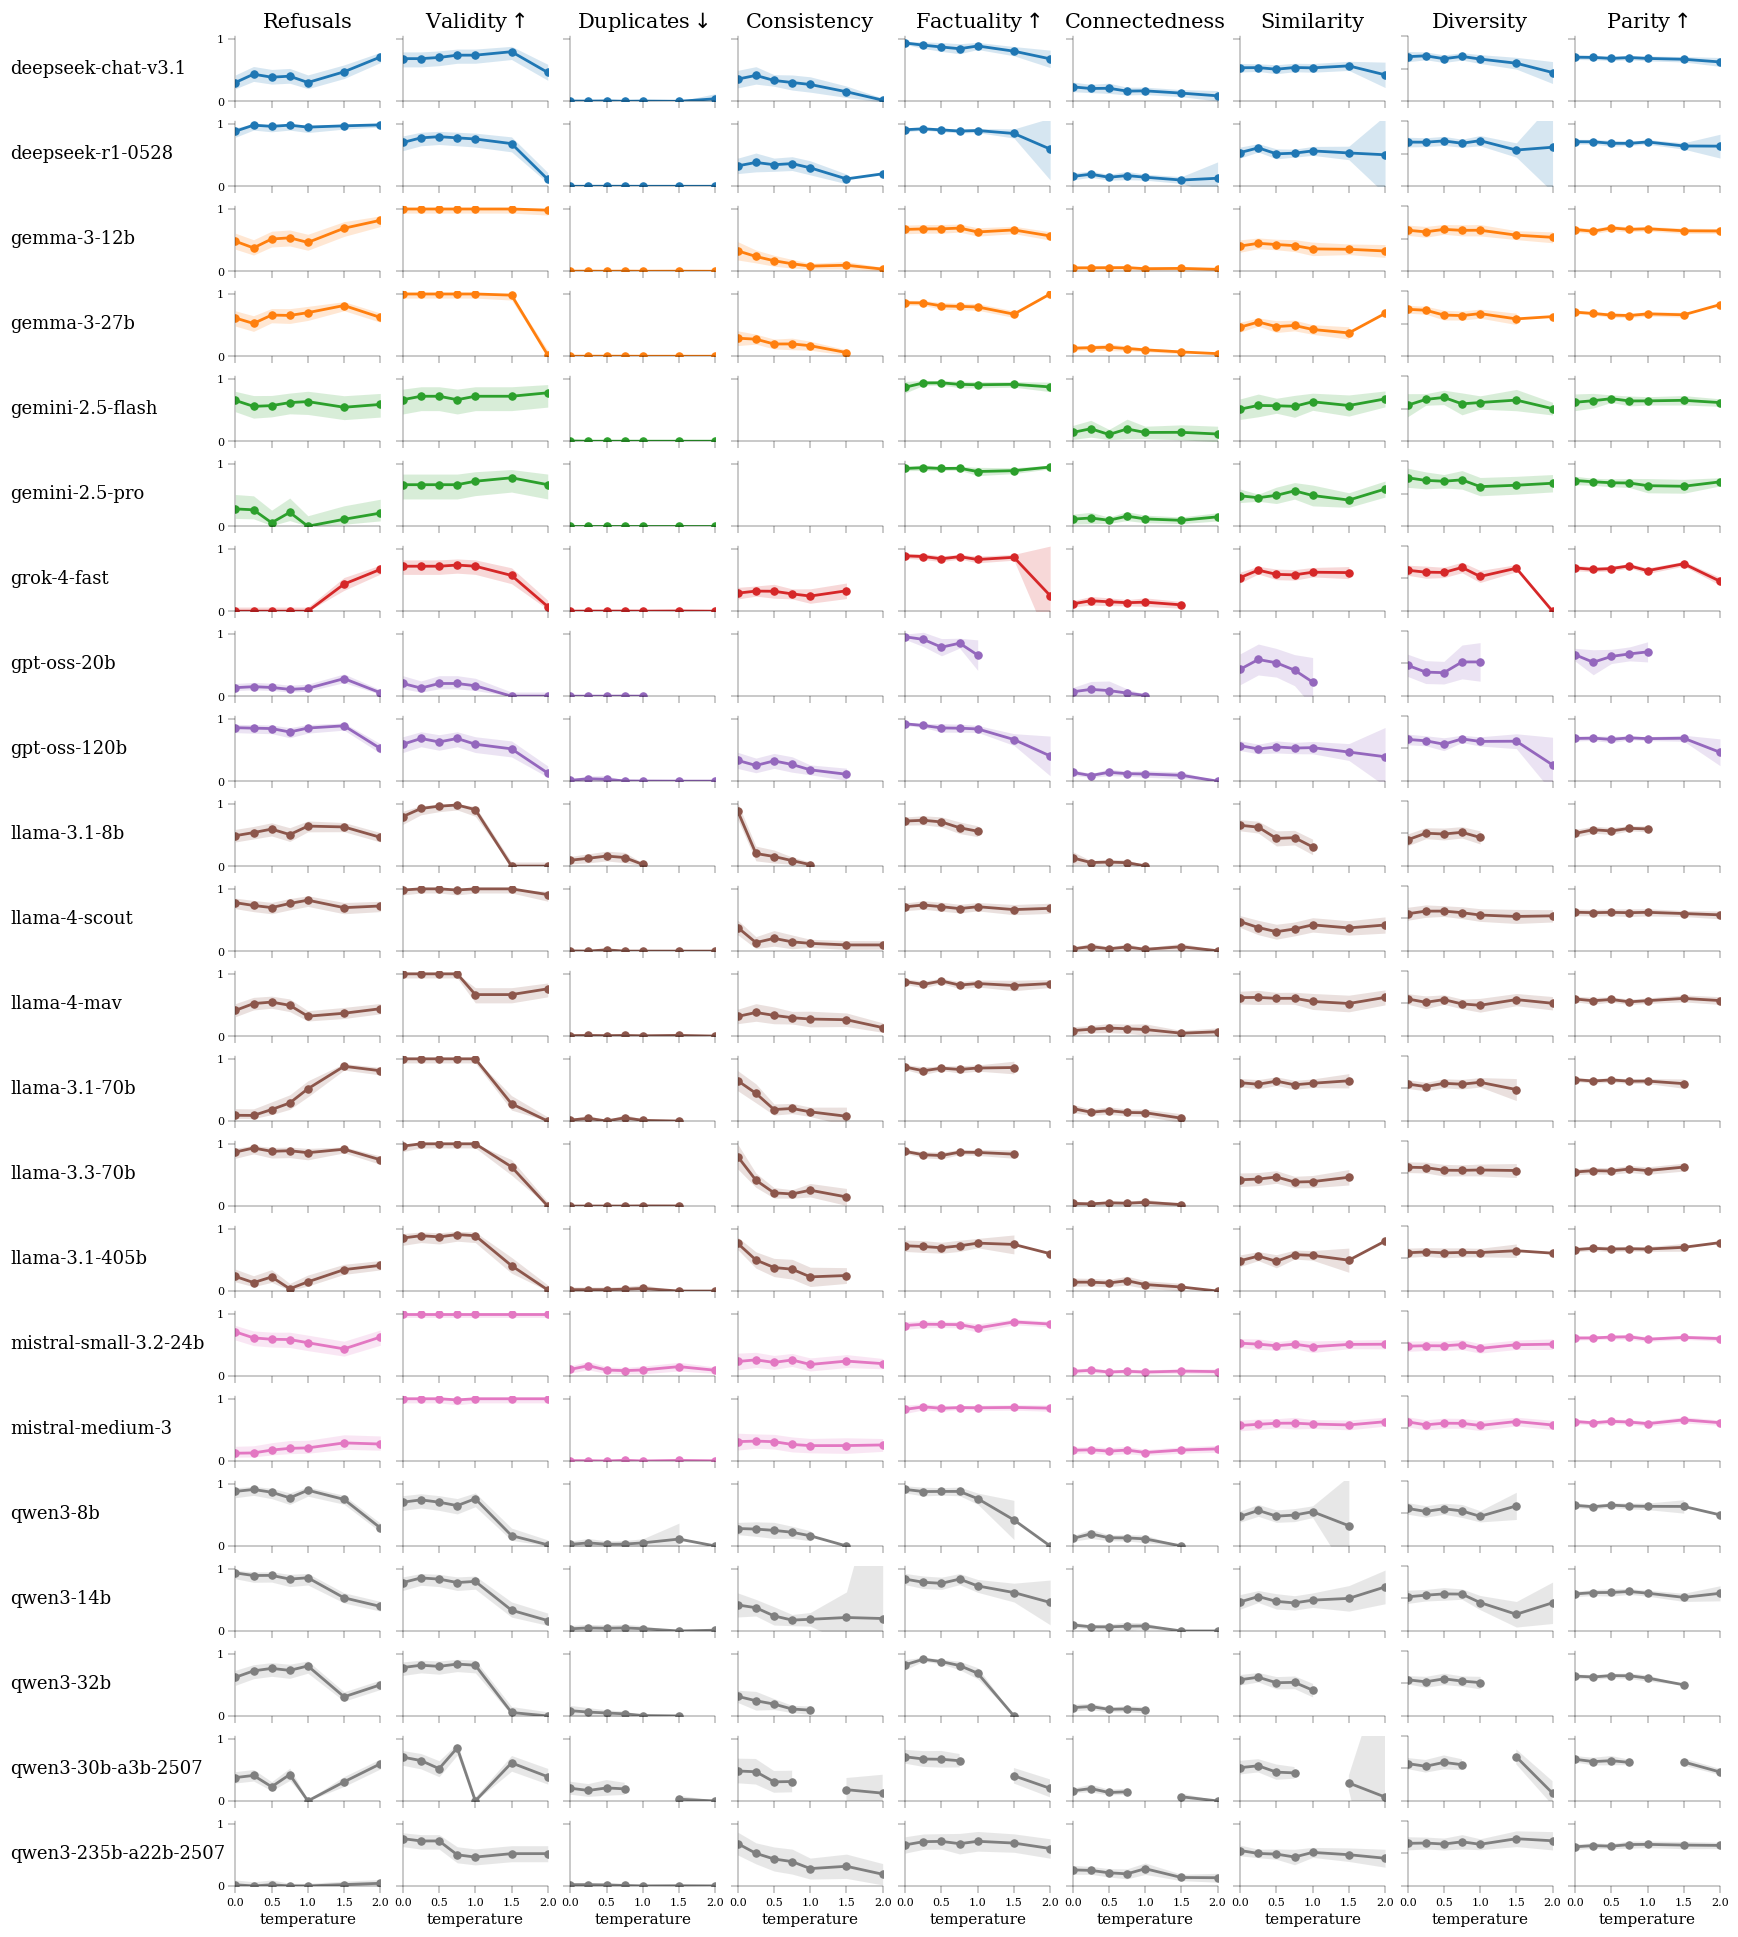

In [11]:
index = ['model', 'provider', 'temperature']
hue_colors = constants.LLM_CLASS_COLORS
group_order = constants.LLMS_ORDERED

values = (
    df_summary_temperature_model.pivot(index=index, columns='metric_name', values='mean')
)

ci_low = (
    df_summary_temperature_model.pivot(index=index, columns='metric_name', values='ci_low')
)

ci_high = (
    df_summary_temperature_model.pivot(index=index, columns='metric_name', values='ci_high')
)

fig = gridline.plot_metric_grid_temperature_from_pivot(
    values,
    ci_low=ci_low,
    ci_high=ci_high,
    panels=gridcons.PANELS_METRICS, 
    left_group_cols=[index[0]],
    series_col=index[1],
    x_col=index[2],
    series_colors=hue_colors,
    group_order=group_order,
    layout=gridline.LayoutSpec(figsize=(18, 25), wspace=0.15, 
                                separator_lw=0.5, 
                                label_ratio=0.42,
                                ),
    style=gridline.StyleSpec(title_fontsize=gridcons.TITLE_FONT_SIZE, 
                             spine_lw=gridcons.SPINE_LW,
                             ylabel_fontsize=gridcons.YLABEL_FONT_SIZE, 
                             tick_fontsize=gridcons.TICK_FONT_SIZE, tick_font_color=gridcons.TICK_FONT_COLOR,
                             value_fontsize=10, legend_fontsize=10, legend_frameon=True, 
                             row_label_x=-0.3, grid_x=False, 
                             grid_y=False, ylabel_pad=10),
single_index_as_ylabel=False,
)

fn = io.path_join(PLOTS_PATH, f'{PREFIX}_by_model.pdf')
if fn is not None:
    fig.savefig(fn, dpi=constants.FIG_DPI, bbox_inches='tight')

gridline.plt.show()
gridline.plt.close()